# Machine learning the physical properties of 2D materials with VT method 

<font color=#000000 size=3 face="黑体"> Author: Xu Lei  <p>   </p>  Email: xulei0553@gmail.com</font>

# Prerequisites

## The following packages should be installed in advance:
## 1. scikit-learn, 2. pymatgen

# 0. Purpose

## This tutorial aims to help learn how to use machine learning to study the material's physical properties. Here, we use a regression machine learning model to predict the band gap of 2D materials, and "2dmatpedia" database is used for training the model.

# 1. Data retrieval 
## First, go to "http://www.2dmatpedia.org/download" and download the 2Dmatpedia database, and then place it in the current directory. Next, extract structure and band gap information for each material from the database, and store the information in a dataframe file.

In [1]:
import numpy as np
import pandas as pd
import json
from pymatgen.core.structure import Structure

# Create an empty dataframe to record the "material_id", "structure" and "band gap" of each 2D material
df=pd.DataFrame(columns=["material_id","structure","bandgap"])
i=0
with open("db.json","r+") as f:
    for line in f:
        data=json.loads(line)        
        #Select the 2D materials with band gap larger than 0, and then write the information into the dataframe.
        if "bandgap" in data.keys() and data["bandgap"]>0:
            df.loc[i,"material_id"]=data["material_id"]
            df.loc[i,"structure"]=Structure.from_dict(data["structure"])
            df.loc[i,"bandgap"]=data["bandgap"]
            i+=1

# 2. Data visualization

## Visualize the distribution of band gap data

### Histogram plot

In [2]:
df["bandgap"].astype('float64').hist(bins=50)

### Violin plot

In [3]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.violinplot(y=df["bandgap"].astype('float64'))

# 3. Feature extraction

## For each 2D material, use Matminer package to exctact 271 VT based features (refer to "Phys. Rev. B 96, 024104" for more details), and store the features into a dataframe named feature_data. At last, save the feature data in a csv file.

In [4]:
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers.structure import (SiteStatsFingerprint, StructuralHeterogeneity, ChemicalOrdering, StructureComposition, MaximumPackingEfficiency)
from matminer.featurizers.composition import ElementProperty, Stoichiometry, ValenceOrbital, IonProperty
from matminer.featurizers.site import CoordinationNumber,LocalPropertyDifference
from matminer.utils.data import MagpieData

element_properties=('Electronegativity','Row','Column','Number','MendeleevNumber','AtomicWeight','CovalentRadius','MeltingT',
         'NsValence','NpValence','NdValence','NfValence','NValence','NsUnfilled','NpUnfilled','NdUnfilled','NfUnfilled',
         'NUnfilled','GSvolume_pa','SpaceGroupNumber','GSbandgap','GSmagmom')

#The following features will be created by using matminer package.
featurizer = MultipleFeaturizer([
    SiteStatsFingerprint(CoordinationNumber().from_preset('VoronoiNN'),stats=('mean','std_dev','minimum','maximum')),
    StructuralHeterogeneity(),
    ChemicalOrdering(),
    MaximumPackingEfficiency(),
    SiteStatsFingerprint(LocalPropertyDifference(properties=element_properties),stats=('mean','std_dev','minimum','maximum','range')),
    StructureComposition(Stoichiometry()),
    StructureComposition(ElementProperty.from_preset("magpie")),
    StructureComposition(ValenceOrbital(props=['frac'])),
    StructureComposition(IonProperty(fast=True))    
])

#Generate VT based features from the material's crystal structure.
feature_data=featurizer.featurize_dataframe(df,col_id=['structure'],ignore_errors=True)
#"structure", "compound possible" and "material_id" are not resonable physical features, so we drop these three columns
feature_data=feature_data.drop(["structure","compound possible","material_id"],axis=1)
#write the data into a csv file for later use
feature_data.to_csv("2dmatpedia_bandgap_data.csv",index=False)

A Jupyter Widget

D:\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning:

Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)



# 4. Machine learning model

## In this tutorial, use Gradient Boosting algorithm as an example to show how to build and run a machine learning model.

### Import relevant packages

In [5]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection import train_test_split,KFold,ShuffleSplit
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



### Read the data from csv file, and assign features and labels to x and y, respectively. Then, split the data into train and test set.

In [6]:
data_df=pd.read_csv("2dmatpedia_bandgap_data.csv")
#fill the NaN with the mean value of the corresponding column
data_df=data_df.fillna(data_df.mean())
y=data_df["bandgap"].values
X=data_df.drop(["bandgap"],axis=1).values
#75% of data is used for training, the rest is for testing.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=1)

### Build a Gradient Boosting regressor model, and tune some model parameters, such as n_estimators and max_depth, to achieve a high score, which corresponds to an optimized model. (Noted that the parameter in the below may not be the optimal one, you can change them by yourself)

In [7]:
lr=GradientBoostingRegressor(n_estimators=700,random_state=1,max_depth=5)
#use 5-fold cross-validation approach to find the best model parameters
cv=ShuffleSplit(n_splits=5,test_size=0.2,random_state=1)
scores=cross_val_score(lr,X_train,y_train,cv=cv,scoring="neg_mean_absolute_error")
print("scores:  ",str(-np.mean(scores)))

scores:   0.5812560914349142


### Traning the optimized model with train data, and then do the prediction for the test set and calculate the mean absolute error

In [8]:
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
#calculate and print test error
print("MAE:  ",np.mean(abs(y_pred-y_test)))

MAE:   0.5514669516003231


# 5. Result analysis

## Visualize the prediction result

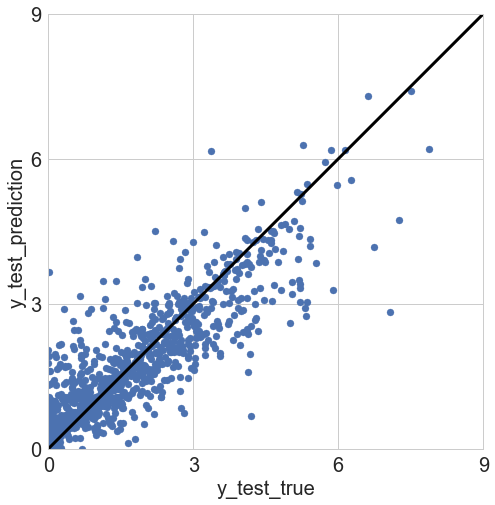

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

x1=np.linspace(0,9,100)
plt.figure(figsize=(8,8))
plt.scatter(y_test,y_pred)
plt.xlim([0,9])
plt.ylim([0,9])
plt.xticks([0,3,6,9],fontsize=20)
plt.yticks([0,3,6,9],fontsize=20)
plt.xlabel("y_test_true",fontsize=20)
plt.ylabel("y_test_prediction",fontsize=20)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(x1,x1,c='k',lw=3)
plt.show()

## Find the five most important features and plot the relative importance

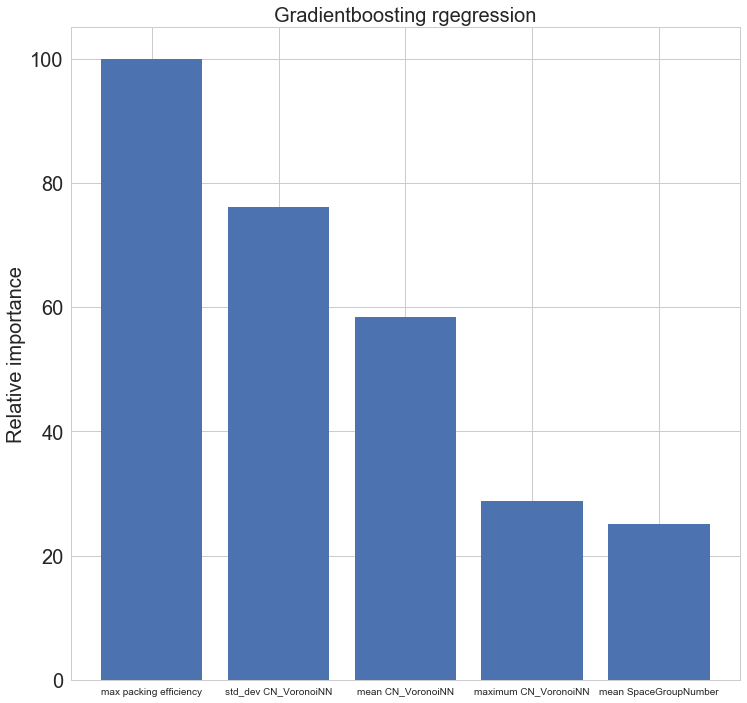

In [10]:
#Define a function to plot the relative feature importance
def plot_feature_importances(feature_importances,title,feature_names):
    feature_importances=100.0*(feature_importances/max(feature_importances))
    index_sorted=np.flipud(np.argsort(feature_importances))[:5]
    pos=np.arange(index_sorted.shape[0])+0.5


    plt.figure(figsize=(12,12))
    plt.bar(pos,feature_importances[index_sorted],align="center")
    plt.xticks(pos,feature_names[index_sorted],fontsize=10)
    plt.yticks([0,20,40,60,80,100],fontsize=20)
    plt.ylabel("Relative importance",fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

#Sort the feature importance in descending order and call plot_feature_importance function to plot them.
features=data_df.drop(["bandgap"],axis=1).columns.values
importances=lr.feature_importances_
indices = np.argsort(importances)[::-1]
plot_feature_importances(importances,"Gradientboosting rgegression",features)


# 6. Assignment

## Use other machine learning algorithms, such as random forest and support vector machine, to build a model and train with the data.
## Except the band gap, try to learning other physical properties, such as formation energy, using the same database 2Dmatpedia
## Outreach: Try to use matminer package to generate other features that could affect the band gap.